In [1]:
from data.database import MongoClient, StoryDataset, MilvusClient
from story.story_dashboard import StoryDashboard

/Users/maoxin/opt/anaconda3/envs/n2_one_click/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
mongo_client = MongoClient()
story_dataset = StoryDataset()
story_dashboard = StoryDashboard(mongo_client, story_dataset)

In [3]:
graph_single_tree, graph_clusters, node_text_map = story_dashboard.get_graph_today()

# of merged subgraphs: 67


In [14]:
story_dashboard[10]

In [11]:
from datetime import datetime, timedelta

In [13]:
expr = {"date_added": {"$gte": datetime.utcnow() - timedelta(days=1)},
        "title": {"$regex": "China"}}

graph_single_tree, graph_clusters, node_text_map = story_dashboard.get_graph(expr, cluster_iou_threshold=0.6)

# of merged subgraphs: 2


In [14]:
story_dashboard[0]

# Visualization Layout Comparison

see https://stackoverflow.com/questions/21978487/improving-python-networkx-graph-layout for details

- conclusion: "neato" and "sfdp" seems better

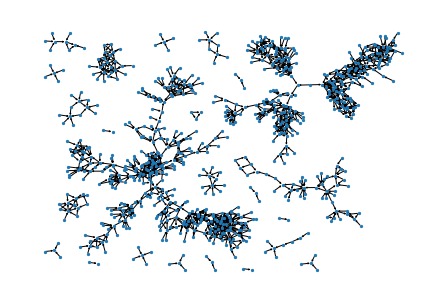

In [50]:
draw(DG_today, prog="neato")

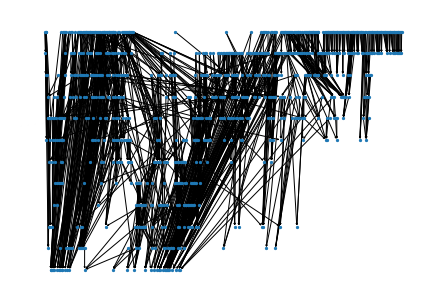

In [17]:
draw(DG, prog="dot")

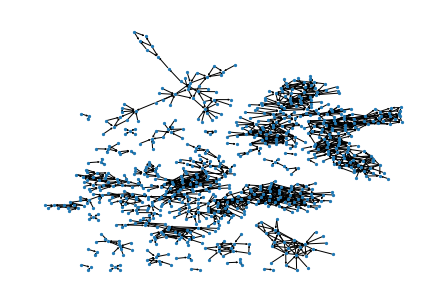

In [43]:
draw(DG_today, prog="fdp")

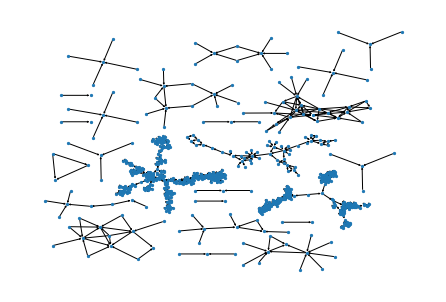

In [44]:
draw(DG_today, prog="sfdp")

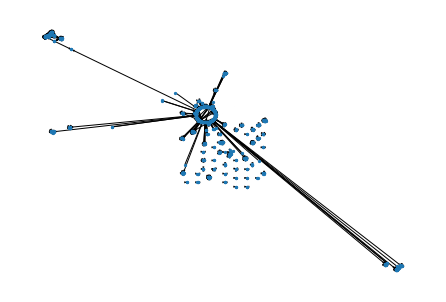

In [21]:
draw(DG, prog="circo")